# Identifikacija zvezd

Postopek določitve višine in azimuta za vse navigacijske zvezde za določen dan,uro in položaj z uporabo navtičnih efemerid

## Kopiranje podatkov iz efemerid in njihovo parsanje

Identifikacija zvezd poteka s pomočjo uporabe navtičnih Efemeridov, kjer dobimo za posamezen dan:
1. **ime** zvezde
2. **rektascenzio** ($\text{Sha}_{\star}$) zvezde
3. **deklinacijo** ($\delta_{\star}$) zvezde
4. **časovni kot** ($\text{Sha}_{\gamma}$) pomladišča

Te podatke je nato potrebno pretvoriti v računalniško berljivo obliko, kar naredimo z naslednjimi funkcijami:
- preberemo vrstico
- parsamo iz vrstice: 
    * ime$_{\star}$,
    * $\text{Sha}_{\star}$,
    * $\delta_{\star}$
    
Nato vse te podatke vstavimo v *list* trojic [['ime','sha','dec'],['ime','sha','dec'],...,['ime','sha','dec']] in izvozimo za nadaljno uporabo in procesiranje.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import re # Paket za Regular Expressions

In [88]:
# convert str list ['dec','min','dec_min'] to float
def str_to_float(fs):
    
    return int(fs[0]) + (int(fs[1]) + int(fs[2])/10)/60

def degmin2degdec(ang):
    
    return ang[0] + ang[1]/60

def degdec2degmin(dd):
    
    mf = np.modf(dd)
    
    return [int(dd(1)), mf(0)*60]

def sortAzimuth(e):
  return e['az']

# read star data file and parse lines
def read_data_file(file_name):
    # opens file and reads lines
    start_file = open(file_name, 'r') 
    Lines = start_file.readlines() 

    data_list = []
    # Strips the newline character 
    for line in Lines: 
        l = line.strip() # clean newline character
        
        s_name = ''
        s_sha = 0
        s_dec = 0
        
        # parse star name
        name = re.compile('[^0-9]+')
        res = name.match(l)
        if res != None:
            s_name = res.group().strip()

        # parse star sha & dec    
        ang = re.compile('[^0-9]?[0-9]+[^0-9]?[0-9]+\.[0-9]+')
        sig_num = re.compile('[\d()-]+')
        res = ang.findall(l)
        if res != None:
            str_sha = sig_num.findall(res[0])
            str_dec = sig_num.findall(res[1])
            
            s_sha = str_to_float(str_sha)
            s_dec = str_to_float(str_dec)
            
        data_list.append([s_name, s_sha, s_dec])
    
    return data_list

def star_alt_azimuth(star_data, fi, la, vGhaA, t, minH, maxH):
    
    N = star_data.shape[0]
    td = degmin2degdec(t)
    dGhaA1 = degmin2degdec(vGhaA[0])
    dGhaA2 = degmin2degdec(vGhaA[1])
    
    if dGhaA2 > dGhaA1:
        GhaA = dGhaA1 + (dGhaA2 - dGhaA1) * np.modf(td)[0]
    else:
        GhaA = dGhaA1 + (dGhaA2 + (360.0 - dGhaA1)) * np.modf(td)[0]
        
    if GhaA > 360.0:
        GhaA -= 360.0
        
    LhaA = GhaA + degmin2degdec(la);
    psi = (90.0 - degmin2degdec(fi)) * np.pi/180
    
    star_nhw = []
    
    for i in range(N):
        name = star_data[i,0]
        Sha = float(star_data[i,1])
        Dec = float(star_data[i,2])
        
        p = (90 - Dec) * np.pi/180.0
        Lha = np.fmod(LhaA + Sha, 360.0) * np.pi/180.0
    
        z = np.arccos(np.cos(psi) * np.cos(p) + np.sin(psi) * np.sin(p) * np.cos(Lha))
        w = np.arccos((np.cos(p) - np.cos(z) * np.cos(psi))/(np.sin(z) * np.sin(psi)))
        if Lha <= np.pi:
            w = 2*np.pi - w
            
        #print('{}: h={:f}, w={:f}'.format(name, 90 - z*180/np.pi, w*180/np.pi))
        
        h = 90 - z*180/np.pi
        w = w*180/np.pi
        if h >= minH and h <= maxH:
            star_nhw.append({'name':name, 'alt':h, 'az':w})
        
    return star_nhw

Polaris    h=46.50,  w= 0.7
Capella    h=33.54,  w=56.2
Mirfak     h=52.09,  w=62.5
Hamal      h=51.78,  w=112.8
Markab     h=58.64,  w=193.4
Enif       h=47.02,  w=221.5
Vega       h=36.77,  w=290.6
Eltanin    h=37.32,  w=308.8
Kochab     h=34.62,  w=345.4


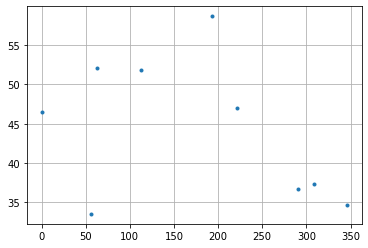

In [95]:
star_data = np.array(read_data_file('star_sha_dec.txt'))
fi = [46, 6]
la = [13, 40]
GhaA = [[332, 25.7], [347, 28.2]]
time = [19, 30, 0]
minH = 30
maxH = 60

star_list = star_alt_azimuth(star_data, fi, la, GhaA, time, minH, maxH)
star_list.sort(key=sortAzimuth)

star_name = []
star_h = []
star_w =[]

for star in star_list:
    name = star['name']
    h = star['alt']
    w = star['az']
    star_name.append(name)
    star_h.append(h)
    star_w.append(w)
    print('{:10s} h={:3.2f},  w={:4.1f}'.format(name, h, w))

plt.plot(star_w, star_h, '.')
plt.grid(True)


Nato je potrebno te podatke pretvoriti v zvezdino višino $\text{H}_{\star}$ in njen azimut $\omega_{\star}$, kjer moramo uporabiti še časovni kot pomladišča $\text{Sha}_{\gamma}$ in naš položaj ($\varphi,\lambda$)za pretvorbo.